# Quantum catalysts in realistic scenarios

## Abstract

<br>

<div style="text-align:justify">
We present a catalytic process in a paradigmatic quantum optics setup, namely the Jaynes-Cummings model, where an atom interacts with an optical cavity. The atom plays the role of the catalyst, and allows for the deterministic generation of non-classical light in the cavity. Considering a cavity prepared in a ``classical'' coherent state, and choosing appropriately the atomic state and the interaction time, we obtain an evolution with the following properties. First, the state of the cavity has been modified, and now features non-classicality, as witnessed by sub-Poissonian statistics or Wigner negativity. Second, the process is catalytic, in the sense that the atom is deterministically returned to its initial state exactly, and could then in principle be re-used multiple times.
</div>


See more in: https://arxiv.org/abs/2305.19324
</div>

## Required packages 

In [2]:
# setup the matplotlib graphics library 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# import required packages 
import qutip as q
import cvxpy as cp
import toqito as tq
from numpy import linalg as lin

import tqdm
import time

## Description

<br>

<div style="text-align:justify">
To demonstrate that the catalytic effect remains robust under dissipation, we assume that the cavity is coupled to an environment characterized by a temperature $T$. This accounts for the cavity loss. We also consider the potential for atom decay via photon emission. As a result, the dynamics of the atom-cavity system are described by a Lindblad master equation, which takes the following form: 
</div>

<br>

<center>
$\dot{\rho}=-i\left[H_{\textsf{JC}},\rho\right]+ \kappa(n_{\textrm{th}}+1)\mathcal{L}[a,\rho] +  \kappa n_{\textrm{th}}\mathcal{L}[a^{\dagger},\rho] + \Gamma \mathcal{L}[\sigma_-,\rho]$,
</center>

<br>

<div style="text-align:justify">
where \( \kappa \) and \( \Gamma \) are the cavity and atom dissipation rate, respectively; \( n_{\textrm{th}}=(e^{1/T}-1)^{-1} \) is the average excitation number and \( \mathcal{L}[L,\rho] = L\rho L^{\dagger} -\frac{1}{2}\{L^{\dagger}L,\rho \} \) is the dissipator in Lindblad with \( \{.\,,\,.\} \) denoting the anticommutator. 
</div>

## Dissipative catalyst evolution finder 

We now present an algorithm devised to uncover the catalytic set for a dissipative quantum system governed by a given Lindbladian superoperator $\mathcal{L}$. The algorithm harnesses the power of semidefinite programming (SDP) to compute the state of the catalyst $\chi_{\textsf C}$ for a given specified time.

In [3]:
def find_catalytic_set_dissipative(rhoS, L, tlist):
    Nt = len(tlist)
    N = L.dims[0][0][0]
    omega_tab = np.zeros((2,2,Nt), dtype = 'complex_')
    
    states = []
    omegas = []
    
    for it in tqdm.tqdm(range(0,Nt)):
        
        t = tlist[it]
        
        Lt = (L*t).expm()
        krauses = q.to_kraus(Lt)
        krauses_tab = [kraus.full() for kraus in krauses]

        ### solve SDP problem
        
        omega = cp.Variable((2,2),complex=True)
        inp = cp.kron(rhoS.full(), omega);

        constraints = [omega >> 0]

        constraints += [omega == cp.partial_trace(cp.sum([K @ inp @ K.conj().transpose() for K in krauses_tab]), 
                                                  dims = (N, 2), axis = 0)]
        constraints += [cp.trace(omega) == 1]

        prob = cp.Problem(cp.Minimize(0), constraints)
        prob.solve()
       
        #####################
        
        omegaC = q.Qobj(omega.value, dims = [[2],[2]])
        
        sigmaSC = sum([K * q.tensor(rhoS, omegaC) * K.dag() for K in krauses])
        states.append(sigmaSC)
        omegas.append(omegaC)
                              
    return states, omegas

## Jaynes-Cummings model

<br>

<div style="text-align:justify">
We discuss the phenomenon of catalysis in the Jaynes-Cummings (JC) model, describing the interaction between a single-mode optical cavity and a two-level atom. We work in the resonant regime, where the atom and cavity have the same frequency $\omega$. The evolution is governed by the JC Hamiltonian, which in the rotating-wave approximation reads 
</div>

<br>

<center>
$H_{\textsf{SC}} = \omega a^{\dagger} a + \frac{\omega}{2} \sigma_z +   g \left(\sigma_+ a + \sigma_- a^{\dagger} \right).$
</center>

<br>
where $g$ is the coupling constant.

# Parameters and definitions

In [44]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
alpha = 1/np.sqrt(2) 
N = 20  # number of cavity fock states
n_th_a = 0.1  # avg number of thermal bath excitation
use_rwa = True
rhoS = q.coherent_dm(N, alpha)
tlist = np.linspace(0,50,101)

# Joint state cavity-atom

rhoSC = q.tensor(rhoS, q.basis(2,1) * q.basis(2,1).dag())  

# operators
a  = q.tensor(q.destroy(N), q.qeye(2))
sp = q.tensor(q.qeye(N), q.destroy(2))
sm = sp.dag()
sz = sp*sm-sm*sp

# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + 0.5*wa * sz + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * a.dag() * a + 0.5*wa * sz + g * (a.dag() + a) * (sm + sm.dag())
    
# dissipators
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

# cavity excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

# qubit relaxation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

## Auxiliary functions 

In [12]:
def plot_wigner(psi, alpha_max = 4):
    fig = plt.figure(figsize=(9,9))

    widths = [6,3]
    heights = [6,3]
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,
                              height_ratios=heights)

    x = np.linspace(-alpha_max,alpha_max,200)
    wig = q.wigner(psi, xvec, xvec)
    psi_x = np.sum(wig,axis=0)
    psi_p = np.sum(wig,axis=1)

    ax = fig.add_subplot(spec[0,0])
    q.plot_wigner(psi,fig=fig,ax=ax,alpha_max = alpha_max)
    ax = fig.add_subplot(spec[0,1])
    base = plt.gca().transData
    rot = mpl.transforms.Affine2D().rotate_deg(90)
    ax.plot(x,-psi_p, transform = rot+base)
    ax.set_xticks([])
    ax.set_ylim(-alpha_max,alpha_max)
    
    ax = fig.add_subplot(spec[1,0])
    ax.plot(x,psi_x)
    ax.set_yticks([]);
    ax.set_xlim(-alpha_max,alpha_max)
    
def toBloch(rho):
    a = rho[0,0]
    b = rho[0,1]
    c = rho[1,0]
    d = rho[1,1]

    x = np.real(c+b);
    y = np.imag(c-b);
    z = np.real(d-a);
    
    return x, y, z

# partial trace with respect to the first subsystem (dim A = n x m) 
def partial_trace_first(A, n, m):
    return np.trace(A.reshape(n,m,n,m), axis1=0, axis2=2) # KEEPS SECOND SYSTEM
    # return np.trace(A.reshape(n,m,n,m), axis1=1, axis2=3) # KEEPS FIRST SYSTEM
    
def plot_wigner_psi(psi, alpha_max = 4):
    fig = plt.figure(figsize=(9,9))

    widths = [6,3]
    heights = [6,3]
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,
                              height_ratios=heights)

    x = np.linspace(-alpha_max,alpha_max,200)
    wig = q.wigner(psi, xvec, xvec)
    psi_x = np.sum(wig,axis=0)
    psi_p = np.sum(wig,axis=1)

    ax = fig.add_subplot(spec[0,0])
    q.plot_wigner(psi,fig=fig,ax=ax,alpha_max = alpha_max)
    ax = fig.add_subplot(spec[0,1])
    base = plt.gca().transData
    rot = mpl.transforms.Affine2D().rotate_deg(90)
    ax.plot(x,-psi_p, transform = rot+base)
    ax.set_xticks([])
    ax.set_ylim(-alpha_max,alpha_max)
    
    ax = fig.add_subplot(spec[1,0])
    ax.plot(x,psi_x)
    ax.set_yticks([]);
    ax.set_xlim(-alpha_max,alpha_max)
    
    plt.xlim([0,tlist[tmax_index]])
    plt.ylim([0,1])

# Check dissipative evolution

In [10]:
# evolve the system
output = q.mesolve(H, rhoSC, tlist, c_ops, [a.dag() * a, sm.dag() * sm])

n_c = output.expect[0]
n_a = output.expect[1]

output = q.mesolve(H, rhoSC, tlist, c_ops, [])

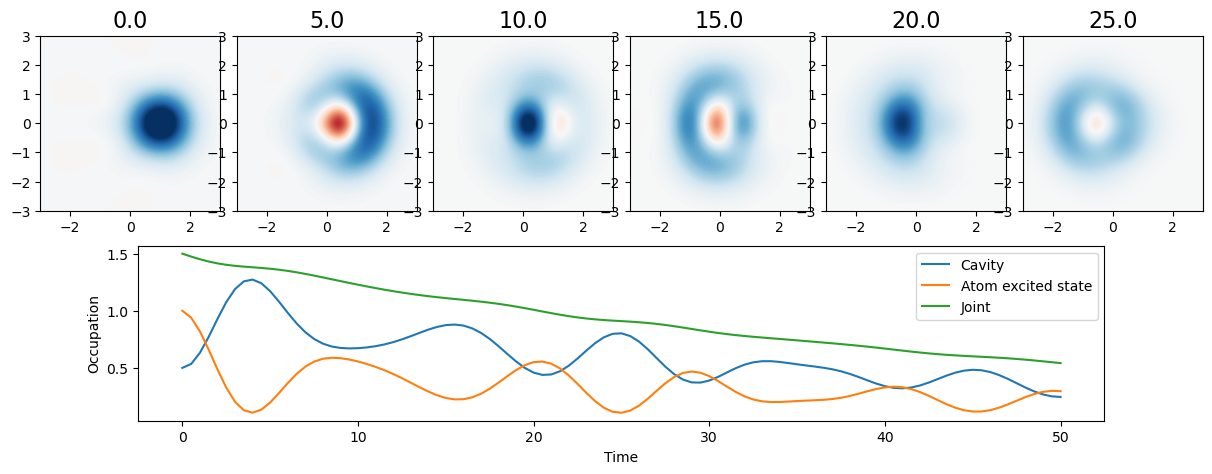

In [11]:
t_idx = np.where([tlist == t for t in [0.0, 5.0, 10, 15, 20, 25]])[1]
rho_list = np.array(output.states)[t_idx]
xvec = np.linspace(-3,3,200)

fig_grid = (2, len(rho_list)*2)
fig = plt.figure(figsize=(2.5*len(rho_list),5))

for idx, rho in enumerate(rho_list):
    rho = q.Qobj(rho)
    rho.dims = [[N,2],[N,2]]
    rho_cavity = q.ptrace(rho, 0)
    W = q.wigner(rho_cavity, xvec, xvec)
    ax = plt.subplot2grid(fig_grid, (0, 2*idx), colspan=2)
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    ax.set_title(f"{tlist[t_idx][idx]}", fontsize=16)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (1, 1), colspan=(fig_grid[1]-2))
ax.plot(tlist, n_c, label="Cavity")
ax.plot(tlist, n_a, label="Atom excited state")
plt.plot(tlist, n_a + n_c, label='Joint')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Occupation');

# Catalytic dissipative evolution

To demonstrate that the catalysis phenomenon is robust under dissipation, one can plot the Wigner logarithmic negativity in the presence of dissipation:

### Auxiliary functions 

In [12]:
L = q.liouvillian(H, c_ops, data_only=False, chi=None)

In [13]:
states, omegas = find_catalytic_set_dissipative(rhoS, L, tlist)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [04:34<00:00,  2.71s/it]


In [14]:
Nx = 200
xvec = np.linspace(-5,5,Nx)

Wmin = 0
Wmin_tab = []
WLN_tab = []

for idx, rho in enumerate(states):

    rho_cavity = rho.ptrace(0)
    
    W = q.wigner(rho_cavity, xvec, xvec)
    W = W / np.sum(W)
    WLN = np.log(np.sum(abs(W)))
    
    Wmin_tab.append(np.min(W))
    WLN_tab.append(WLN)

ind_wln_max = np.argmax(WLN_tab)
ind_w_min = np.argmin(Wmin_tab)